In [1421]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np

In [1422]:
# | export


def complex_oscillator_exp(
    z: torch.ComplexType,
    initial_phase: torch.ComplexType = None,
    N: int = 2048,
    constrain: bool = False,
    reduce: bool = False,
):
    """Generates an exponentially decaying sinusoid from a complex number."""

    if initial_phase is None:
        # If no initial phase is provided, use zero phase.
        # Note that in the complex representation, zero phase is equivalent to a real number.
        initial_phase = torch.ones_like(z)
    
    if constrain:
        # Limit the magnitude of z to 1. Note that tanh is used in lieu of sigmoid to 
        # avoid vanishing gradients as magnitude approaches zero.
        mag = torch.abs(z)
        z = z * torch.tanh(mag) / mag

    z = z[..., None].expand(*z.shape, N - 1)
    z = torch.cat([initial_phase.unsqueeze(-1), z], dim=-1)
    
    y = z.cumprod(dim=-1)

    if reduce:
        y = y.sum(dim=-2)

    return y

In [1423]:
N = 1024
n = torch.arange(N)

#torch.random.manual_seed(1000)
starting_freq = torch.tensor([0.5]) * math.pi #torch.rand(1) * math.pi
predicted_z = torch.exp(1j * starting_freq)
predicted_z.detach_().requires_grad_(True)
sig = 0.5

target_freq = torch.tensor(0.7) * math.pi
target_signal = torch.exp(1j*target_freq * n) + sig**2/2 * torch.complex(torch.randn(n.shape),torch.randn(n.shape))


torch.float32 torch.float32
torch.Size([1024]) torch.Size([1024])


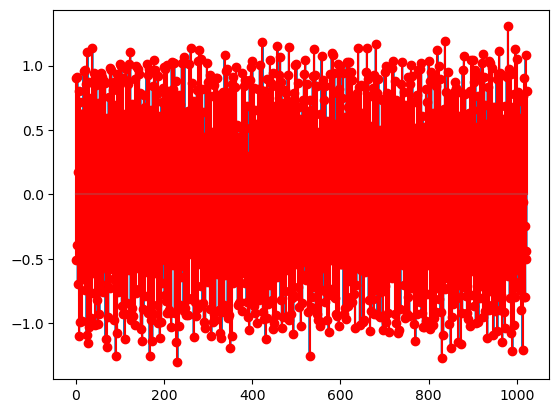

In [1424]:
M = 1024

idx = np.sort(np.random.choice(np.arange(N),(M,),replace=False))


sampling_vector = torch.zeros((N,))
sampling_vector[idx] = 1

sampling_matrix = torch.diag(sampling_vector)


print(sampling_matrix.dtype,torch.real(target_signal.unsqueeze(1)).dtype)

randomly_sampled_signal = torch.complex(sampling_matrix @ torch.real(target_signal.unsqueeze(1)),sampling_matrix @ torch.imag(target_signal.unsqueeze(1)))

print(randomly_sampled_signal.squeeze().shape,target_signal.shape)
plt.plot(torch.real(target_signal))
plt.stem(torch.real(randomly_sampled_signal.squeeze()),'r')
plt.show()

In [1425]:
numiter = 10000
criterion = torch.nn.MSELoss()
optimiser = torch.optim.SGD([predicted_z], lr=3e-4)
z_hist = torch.complex(torch.zeros(numiter,1),torch.zeros(numiter,1))
print(f"Starting frequency: {predicted_z.angle().abs().item():.3f}")

for step in range(numiter):
    z_hist[step] = predicted_z
    predicted_signal = complex_oscillator_exp(predicted_z, N=N, reduce=True).squeeze()
    loss = criterion(torch.real(predicted_signal[idx]), torch.real(target_signal[idx])) + criterion(torch.imag(predicted_signal[idx]), torch.imag(target_signal[idx]))
    optimiser.zero_grad()
    loss.backward()
    predicted_z.grad = predicted_z.grad / predicted_z.grad.abs()
    optimiser.step()

    if (step + 1) % 1000 == 0:
        print(f"--- Step: {step + 1} ---")
        print(f"Predicted frequency: {predicted_z.angle().abs().item():.3f}")
        print(f"Target frequency: {target_freq.item():.3f}")


Starting frequency: 1.571
--- Step: 1000 ---
Predicted frequency: 1.584
Target frequency: 2.199
--- Step: 2000 ---
Predicted frequency: 1.992
Target frequency: 2.199
--- Step: 3000 ---
Predicted frequency: 2.194
Target frequency: 2.199
--- Step: 4000 ---
Predicted frequency: 2.199
Target frequency: 2.199
--- Step: 5000 ---
Predicted frequency: 2.199
Target frequency: 2.199
--- Step: 6000 ---
Predicted frequency: 2.199
Target frequency: 2.199
--- Step: 7000 ---
Predicted frequency: 2.199
Target frequency: 2.199
--- Step: 8000 ---
Predicted frequency: 2.199
Target frequency: 2.199
--- Step: 9000 ---
Predicted frequency: 2.199
Target frequency: 2.199
--- Step: 10000 ---
Predicted frequency: 2.199
Target frequency: 2.199


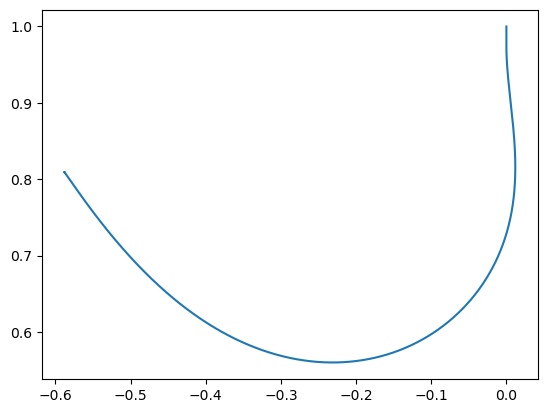

tensor([-4.3711e-08+1.j])
tensor([-0.5879+0.8092j], requires_grad=True)


In [1426]:
plt.plot(torch.real(z_hist).detach().numpy(),torch.imag(z_hist).detach().numpy())
plt.show()

print(torch.exp(1j * starting_freq))
print(predicted_z)

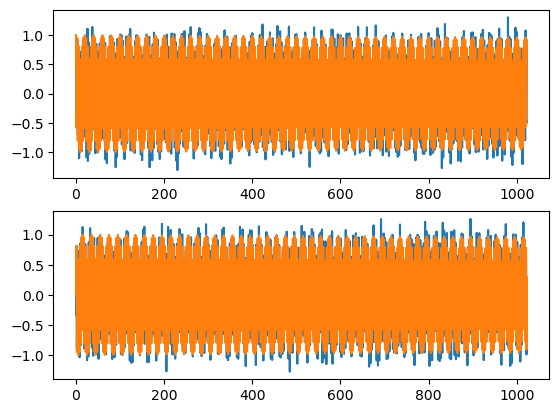

In [1427]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(torch.real(target_signal))
plt.plot(torch.real(predicted_signal).detach().numpy())

plt.subplot(2,1,2)
plt.plot(torch.imag(target_signal))
plt.plot(torch.imag(predicted_signal).detach().numpy())

plt.show()